In [1]:
%matplotlib nbagg
import numpy as np
import scipy as sp
from scipy import linalg
from scipy import interpolate
from scipy import integrate
import matplotlib.pyplot as plt

# Define a Nonlinear Model
We consider the following nonlinear system
\begin{equation}
\begin{split}
    \dot{x}_1 &= -x_1 + \beta x_1 x_3 + u \\
    \dot{x}_2 &= -2 x_2 + \beta x_2 x_3 + u \\
    \dot{x}_3 &= -5 x_3 + u \\
    y &= x_1 + x_2 + x_3
\end{split}
\end{equation}
for fairly large $\beta$.

In [30]:
n_states = 3
n_inputs = 1
n_outputs = 1

beta = 20.0

# The Full-Order Model (FOM) is defined by
# dx/dt = Ax + Bu + einsum('ijk,j,k', H, x, x) + einsum('i, ijk, k', u, N, x)
# y = Cx

## linear part of FOM
A_FOM = np.array([[-1.0, 0.0, 0.0], \
                  [0.0, -2.0, 0.0], \
                  [0.0, 0.0, -5.0]])

B_FOM = np.array([[1.0], \
                  [1.0], \
                  [1.0]])

C_FOM = np.array([[1.0, 1.0, 1.0]])

## nonlinear part of FOM
H_FOM = np.zeros((n_states, n_states, n_states))
H_FOM[0, 0, 2] = beta
H_FOM[1, 1, 2] = beta

# symmetrize the quadratic term
H_FOM = (H_FOM + np.transpose(H_FOM, axes=(0,2,1))) / 2.0


N_FOM = np.zeros((n_states, n_inputs, n_states))

# full-order model
def FOM(x, u):
    f = np.einsum('ij,...j', A_FOM, x) + np.einsum('ij,...j', B_FOM, u) + \
        np.einsum('ijk,...j,...k', H_FOM, x, x) + np.einsum('ijk,...j,...k', N_FOM, u, x)
    return f

# observation function
def FOM_obs(x):
    g = np.einsum('ij,...j', C_FOM, x)
    return g

# derivative of full-order model acting on v
def d_FOM(x, u, v):
    df_v = np.einsum('ij,...j', A_FOM, v) + \
        2.0*np.einsum('ijk,...j,...k', H_FOM, x, v) + np.einsum('ijk,...j,...k', N_FOM, u, v)
    return df_v

# derivative of observation function acting on v
def d_FOM_obs(x, v):
    dg_v = np.einsum('ij,...j', C_FOM, v)
    return dg_v

# adjoint of FOM acting on w
def d_FOM_adj(x, u, w):
    df_T_w = np.einsum('ji,...j', A_FOM, w) + \
        2.0*np.einsum('kji,...j,...k', H_FOM, x, w) + np.einsum('kji,...j,...k', N_FOM, u, w)
    return df_T_w

# adjoint of observations acting on w
def d_FOM_obs_adj(x, w):
    dg_T_w = np.einsum('ji,...j', C_FOM, w)
    return dg_T_w

In [31]:
# given bi-orthogonal bases Phi, Psi for subspaces V, W, assemble tensors
# defining the ROM
def get_ROM_tensors(Phi, Psi):
    A_ROM = np.einsum('ji, jk, kl', Psi, A_FOM, Phi)
    B_ROM = np.einsum('ji, jk', Psi, B_FOM)
    C_ROM = np.einsum('ij, jk', C_FOM, Phi)
    H_ROM = np.einsum('ji,jkl,km,ln', Psi, H_FOM, Phi, Phi)
    N_ROM = np.einsum('ji,jkl,lm', Psi, N_FOM, Phi)
    return A_ROM, B_ROM, C_ROM, H_ROM, N_ROM

## Validate derivatives and adjoints

In [32]:
# step size for finite differences
eps = 1.0e-8

# random state and input
x = np.random.randn(n_states)
u = np.random.randn(n_inputs)

# random vector tangent to state
v = np.random.randn(n_states)

# validate derivative of FOM and observation function
df_v_FD = (FOM(x+eps*v,u) - FOM(x,u))/eps
df_v = d_FOM(x,u,v)
print(np.linalg.norm(df_v - df_v_FD) / np.linalg.norm(df_v_FD)) # (should be about 0)

dg_v_FD = (FOM_obs(x+eps*v) - FOM_obs(x))/eps
dg_v = d_FOM_obs(x,v)
print(np.linalg.norm(dg_v - dg_v_FD) / np.linalg.norm(dg_v_FD)) # (should be about 0)

# random vector tangent to state
w = np.random.randn(n_states)

# validate adjoint of derivative of FOM using definition of adjoint
IP1 = np.dot(d_FOM(x,u,v), w)
IP2 = np.dot(v, d_FOM_adj(x,u,w))
print(np.linalg.norm(IP2 - IP1)/np.linalg.norm(IP1)) # (should be about 0)

# random vector tangent to output
w = np.random.randn(n_outputs)

# validate adjoint of derivative of observation function using definition of adjoint
IP1 = np.dot(d_FOM_obs(x,v), w)
IP2 = np.dot(v, d_FOM_obs_adj(x,w))
print(np.linalg.norm(IP2 - IP1)/np.linalg.norm(IP1)) # (should be about 0)

2.174405679142559e-08
1.2156466767320493e-08
6.842804013243443e-16
2.1379240294323864e-16


# Generate training trajectories
We consider some nonlinear impulse responses.

In [67]:
# set tolerance for solvers
atol = 1.0e-9
rtol = 1.0e-6
solver_method = 'RK45'

In [68]:
# number of trajectories
n_traj = 2

# initial conditions
IC_amps = np.linspace(0.5,1,n_traj)
traj_ICs = [np.ones(n_states)*IC_amps[k] for k in range(n_traj)]

# inputs along trajectories (to be interpolated)
traj_time = np.linspace(0, 5.0, 1001)
u_trajs = [np.reshape(0.0*traj_time, (-1,1)) for k in range(n_traj)]

FOM_x_trajs = [_ for _ in range(n_traj)]
FOM_y_trajs = [_ for _ in range(n_traj)]

for k in range(n_traj):
    # interpolate the input
    u_fun = sp.interpolate.interp1d(traj_time, u_trajs[k], axis=0)
    
    # initial condition
    x0 = traj_ICs[k]
    
    # simulate the FOM
    sol = sp.integrate.solve_ivp(lambda t,x: FOM(x, u_fun(t)), \
                                 # jac = lambda t,x: d_FOM(x, u_fun(t), np.eye(n_states)), \
                                 t_span = [traj_time[0], traj_time[-1]], \
                                 y0 = x0, \
                                 t_eval = traj_time, \
                                 method = solver_method, \
                                 atol=atol, rtol=rtol)
    
    FOM_x_trajs[k] = sol.y.T
    FOM_y_trajs[k] = FOM_obs(sol.y.T)

## Generate data by sampling the trajectories

In [69]:
t_data = traj_time[::100]
y_traj_data = [FOM_y_trajs[k][::100,:] for k in range(n_traj)]
x_traj_data = [FOM_x_trajs[k][::100,:] for k in range(n_traj)]

In [70]:
k=0

<IPython.core.display.Javascript object>


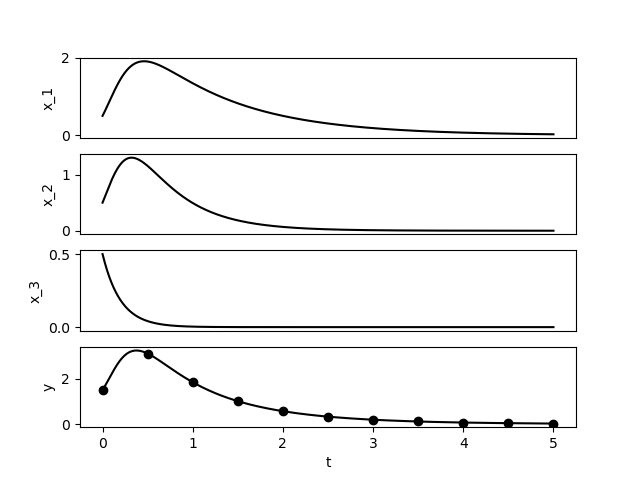

In [71]:
fig = plt.figure()
ax = fig.add_subplot(4,1,1)
ax.plot(traj_time, FOM_x_trajs[k][:,0], 'k-')
ax.set_ylabel('x_1')
ax.set_xticks([])

ax = fig.add_subplot(4,1,2)
ax.plot(traj_time, FOM_x_trajs[k][:,1], 'k-')
ax.set_ylabel('x_2')
ax.set_xticks([])

ax = fig.add_subplot(4,1,3)
ax.plot(traj_time, FOM_x_trajs[k][:,2], 'k-')
ax.set_ylabel('x_3')
ax.set_xticks([])

ax = fig.add_subplot(4,1,4)
ax.plot(traj_time, FOM_y_trajs[k][:,0], 'k-')
ax.plot(t_data, y_traj_data[k][:,0], 'ko')
ax.set_ylabel('y')
ax.set_xlabel('t')

k = (k + 1) % n_traj

# Covariance Balancing

## State and gradient sampling

In [72]:
# horizon length
L = 5
delta_t_samples = (t_data[1]-t_data[0])

# number of samples per trajectories
n_samples = len(t_data)*(L+1) # 100

### state sample matrix
X = np.vstack(x_traj_data).T / np.sqrt(n_traj * len(t_data))

### construct gradient sample matrix
Y_samples = [_ for _ in range(n_traj*n_samples)]

for k in range(n_traj):
    # interpolate the input
    u_fun = sp.interpolate.interp1d(traj_time, u_trajs[k], axis=0, \
                                    bounds_error = False, \
                                    fill_value=(u_trajs[k][0,:], u_trajs[k][-1,:]))
    
#     # generate random final time samples
#     tf_idx_samples = np.zeros(n_samples, dtype=np.intp)
#     for i in range(n_samples):
#         t_idx = np.random.randint(0, len(t_data))
#         tau_idx = np.random.randint(0, L)
#         tf_idx_samples[i] = t_idx + tau_idx
    
    # generate deterministic final time samples
    tf_idx_samples = np.zeros(n_samples, dtype=np.intp)
    for i in range(len(t_data)):
        for j in range(L+1):
            tf_idx_samples[i*(L+1)+j] = i + j
    
    # loop through samples
    for i in range(n_samples):
        ## define the mini-trajectory
        
        # final time index
        tf_idx = tf_idx_samples[i]
        
        # overlap with base trajectory (t = tf - tau)
        tau_idx_min = max(0, tf_idx-len(t_data))
        tau_idx_max = min(L, tf_idx)
        nu = 1 + tau_idx_max - tau_idx_min
        tau_idx_samples = np.arange(tau_idx_min, tau_idx_max+1)
        tau_samples = tau_idx_samples * delta_t_samples
        
        # initial time index
        t0_idx = tf_idx - tau_idx_max
        
        # initial and final times for mini-traj
        t0 = t_data[t0_idx]
        tf = t0 + delta_t_samples*(tf_idx - t0_idx)
        
        ## simulate forward along mini-trajectory
        x0 = x_traj_data[k][t0_idx,:]
        
        if t0_idx < tf_idx:
            sol = sp.integrate.solve_ivp(lambda t,x: FOM(x, u_fun(t)), \
                                         t_span = [t0, tf], \
                                         y0 = x0, \
                                         dense_output = True, \
                                         method = solver_method, \
                                         atol=atol, rtol=rtol)
            
            # interpolants of the FOM solution
            x_fun = lambda t: sol.sol(t).T
            
            ## simulate adjoint
            
            # random isotropic vector
            eta = np.sqrt(L+1) * np.random.randn(n_outputs)
            
            lam0 = d_FOM_obs_adj(x_fun(tf), eta)
            
            adj_sol = sp.integrate.solve_ivp(lambda tau, lam: d_FOM_adj(x_fun(tf-tau), u_fun(tf-tau), lam), \
                                             t_span = [0, tau_samples[-1]], \
                                             y0 = lam0, \
                                             t_eval = tau_samples, \
                                             method = solver_method, \
                                             atol=atol, rtol=rtol)
        
            
            Y_samples[n_samples*k + i] = adj_sol.y / np.sqrt(nu)
        else:
            # random isotropic vector
            eta = np.sqrt(L+1) * np.random.randn(n_outputs)
            
            lam0 = d_FOM_obs_adj(x0, eta)
            
            Y_samples[n_samples*k + i] = np.reshape(lam0, (-1,1))

# stack adjoint samples
Y = np.hstack(Y_samples) / np.sqrt(n_traj*n_samples)

## Balancing transformation

In [73]:
# Hankel matrix SVD
U, s, VT = np.linalg.svd(np.dot(Y.T, X), full_matrices=False, compute_uv=True)

Ur = U[:, :2]
sr = s[:2]
Vr = VT[:2, :].T

# construct projection operator
Phi_cbal = np.dot(X, Vr) / np.sqrt(sr)
Psi_cbal = np.dot(Y, Ur) / np.sqrt(sr)

# construct reduced-order model
A_cbal, B_cbal, C_cbal, H_cbal, N_cbal = get_ROM_tensors(Phi_cbal, Psi_cbal)

def cbal_ROM(z, u):
    f = np.einsum('ij,...j', A_cbal, z) + np.einsum('ij,...j', B_cbal, u) + \
    np.einsum('ijk,...j,...k', H_cbal, z, z) + np.einsum('ijk,...j,...k', N_cbal, u, z)
    return f

# construct observation function
def cbal_ROM_obs(z):
    g = np.einsum('ij,...j', C_cbal, z)
    return g

# POD ROM

In [74]:
U, _, _ = np.linalg.svd(np.vstack(x_traj_data).T, full_matrices=False, compute_uv=True)
Phi_POD = U[:,:2]
Psi_POD = U[:,:2]

print(Phi_POD)

# construct reduced-order model
A_POD, B_POD, C_POD, H_POD, N_POD = get_ROM_tensors(Phi_POD, Psi_POD)

def POD_ROM(z, u):
    f = np.einsum('ij,...j', A_POD, z) + np.einsum('ij,...j', B_POD, u) + \
    np.einsum('ijk,...j,...k', H_POD, z, z) + np.einsum('ijk,...j,...k', N_POD, u, z)
    return f

# construct observation function
def POD_ROM_obs(z):
    g = np.einsum('ij,...j', C_POD, z)
    return g

[[ 0.90938973  0.41580992]
 [ 0.41593493 -0.90889369]
 [ 0.00290838 -0.03184929]]


# Balanced Truncation ROM

In [75]:
def balancing_transformation(A, B, C):
    # compute the observability and controllability Gramians
    Wc = sp.linalg.solve_lyapunov(A, -np.dot(B, B.T))
    Wo = sp.linalg.solve_lyapunov(A.T, -np.dot(C.T, C))

    # compute Cholesky factorizations
    X = np.linalg.cholesky(Wc)
    Y = np.linalg.cholesky(Wo)

    # compute balancing transformation
    U, Hankel_sig, VT = np.linalg.svd(np.dot(Y.T, X), compute_uv=True, \
        full_matrices=False)
    
    H_sig_invsqrt = np.reshape(1.0/np.sqrt(Hankel_sig), (1,len(Hankel_sig)))
    
    Phi = np.dot(X, VT.T) * H_sig_invsqrt
    Psi = np.dot(Y, U) * H_sig_invsqrt

    return Phi, Psi, Hankel_sig

In [76]:
Phi_bal, Psi_bal, H_sig = balancing_transformation(A_FOM, B_FOM, C_FOM)
Phi_bal = Phi_bal[:,:2]
Psi_bal = Psi_bal[:,:2]

print(Phi_bal)
print(Psi_bal)

# construct reduced-order model
A_bal, B_bal, C_bal, H_bal, N_bal = get_ROM_tensors(Phi_bal, Psi_bal)

def bal_ROM(z, u):
    f = np.einsum('ij,...j', A_bal, z) + np.einsum('ij,...j', B_bal, u) + \
    np.einsum('ijk,...j,...k', H_bal, z, z) + np.einsum('ijk,...j,...k', N_bal, u, z)
    return f

# construct observation function
def bal_ROM_obs(z):
    g = np.einsum('ij,...j', C_bal, z)
    return g

[[-0.77957139  0.54079218]
 [-0.55070298 -0.3515968 ]
 [-0.29831975 -0.76414888]]
[[-0.77957139  0.54079218]
 [-0.55070298 -0.3515968 ]
 [-0.29831975 -0.76414888]]


# QB Balancing ROM

papers:

P. Benner and P. Goyal, "Balanced truncation model order reduction for quadratic-bilinear control systems", arXiv:1705.00160v1, 2017

and

B. Kramer and K. Willcox, "Balanced truncation model reduction for lifted nonlinear systems", arXiv:1907.12084v2, 2019

In [77]:
def QB_balancing_transformation(A, B, C, H, N):
    '''
    Quadratic Bilinear Balanced Truncation method given in 
    P. Benner and P. Goyal, "Balanced truncation model order reduction for 
    quadratic-bilinear control systems", arXiv:1705.00160v1, 2017
    and in
    B. Kramer and K. Willcox, "Balanced truncation model reduction for lifted
    nonlinear systems", arXiv:1907.12084v2, 2019

    dx/dt = Ax + Bu + einsum('ijk,j,k', H, x, x) + einsum('i, ijk, k', u, N, x)
    y = Cx
    '''
    # symmetrize the tensor H
    H = (H + np.transpose(H, axes=(0,2,1))) / 2.0

    # mode-2 permutation of H
    H_2 = np.transpose(H, axes=(2,1,0))

    # compute observability and controllability Grammians for linear part
    P1 = sp.linalg.solve_continuous_lyapunov(A, -np.dot(B, B.T))
    Q1 = sp.linalg.solve_continuous_lyapunov(A.T, -np.dot(C.T, C))

    # compute the truncated QB Grammians
    RHS1 = np.einsum('ijk,jl,km,nlm', H, P1, P1, H) \
        + np.einsum('ijk, kl, iml', N, P1, N) + np.dot(B, B.T)
    PT = sp.linalg.solve_continuous_lyapunov(A, -RHS1)

    RHS2 = np.einsum('ijk,jl,km,nlm', H_2, P1, Q1, H_2) \
        + np.einsum('ikj, kl, ilm', N, Q1, N) + np.dot(C.T, C)
    QT = sp.linalg.solve_continuous_lyapunov(A.T, -RHS2)

    # compute Cholesky factorizations
    X = np.linalg.cholesky(PT)
    Y = np.linalg.cholesky(QT)

    # compute balancing transformation
    U, Hankel_sig, VT = np.linalg.svd(np.dot(Y.T, X), compute_uv=True, \
        full_matrices=False)
    
    H_sig_invsqrt = np.reshape(1.0/np.sqrt(Hankel_sig), (1,len(Hankel_sig)))
    
    Phi = np.dot(X, VT.T) * H_sig_invsqrt
    Psi = np.dot(Y, U) * H_sig_invsqrt

    return Phi, Psi, Hankel_sig

In [78]:
Phi_QBbal, Psi_QBbal, H_sig = QB_balancing_transformation(A_FOM, B_FOM, C_FOM, H_FOM, N_FOM)
Phi_QBbal = Phi_QBbal[:,:2]
Psi_QBbal = Psi_QBbal[:,:2]

print(Phi_QBbal)
print(Psi_QBbal)

# construct reduced-order model
A_QBbal, B_QBbal, C_QBbal, H_QBbal, N_QBbal = get_ROM_tensors(Phi_QBbal, Psi_QBbal)

def QBbal_ROM(z, u):
    f = np.einsum('ij,...j', A_QBbal, z) + np.einsum('ij,...j', B_QBbal, u) + \
    np.einsum('ijk,...j,...k', H_QBbal, z, z) + np.einsum('ijk,...j,...k', N_QBbal, u, z)
    return f

# construct observation function
def QBbal_ROM_obs(z):
    g = np.einsum('ij,...j', C_QBbal, z)
    return g

[[-1.1314695   0.41368501]
 [-0.59618058 -0.15940043]
 [-0.03491695 -0.38878161]]
[[-0.68277283  0.16462479]
 [-0.34732464 -0.17628347]
 [-0.58410477 -2.32469209]]


# TQB IRKA ROM

paper:

P. Benner, P. Goyal, and S. Gugercin, "H2-quasi-optimal model order reduction for quadratic-bilinear control systems", SIAM Journal on Matrix Analysis and Applications, Vol. 39, No. 2, 2018

In [79]:
def _biorthogonalize(V, W):
    Phi, _ = np.linalg.qr(V, mode='reduced')
    Psi = np.transpose(np.linalg.solve(np.dot(W.T, Phi), W.T))
    return Phi, Psi

def QB_projection(A, B, C, H, N, Phi, Psi):
    A_hat = np.dot(Psi.T, np.dot(A, Phi))
    B_hat = np.dot(Psi.T, B)
    C_hat = np.dot(C, Phi)
    H_hat = np.einsum('ji, jkl, km, ln', Psi, H, Phi, Phi)
    N_hat = np.einsum('ijk, jl, km', N, Psi, Phi)
    return A_hat, B_hat, C_hat, H_hat, N_hat

def TQB_IRKA(A, B, C, H, N, V, W, tol=1.0e-5):
    '''
    Truncated Quadratic Bilinear Iterative Rational Krylov Algorithm given in
    P. Benner, P. Goyal, and S. Gugercin, "H2-quasi-optimal model order
    reduction for quadratic-bilinear control systems", SIAM J. Matrix Anal. 
    Appl., Vol. 39, No. 2, 2018

    dx/dt = Ax + Bu + einsum('ijk,j,k', H, x, x) + einsum('i, ijk, k', u, N, x)
    y = Cx
    '''
    # symmetrize the tensor H
    H = (H + np.transpose(H, axes=(0,2,1))) / 2.0

    # mode-2 permutation of H
    H_2 = np.transpose(H, axes=(2,1,0))

    # determine initial reduced matrices
    Phi, Psi = _biorthogonalize(V, W)
    A_hat, B_hat, C_hat, H_hat, N_hat = QB_projection(A, B, C, H, N, Phi, Psi)

    # spectral decomposition of A_hat
    lam = sp.linalg.eigvals(A_hat)

    # TQB-IRKA iteration
    e_vals_0 = np.copy(lam)
    rel_diff = np.inf
    iter = 0
    while rel_diff > tol:
        # mode-2 transformation of H_tilde
        H_hat_2 = np.transpose(H_hat, axes=(2,1,0))

        # V1 Sylvester equation
        Q1 = np.dot(B, B_hat.T) # conj(B_tilde.T)?
        V1 = sp.linalg.solve_sylvester(-A, -A_hat.T, Q1)

        # V2 Sylvester equation
        Q2 = np.einsum('ijk, jl, km, nlm', H, V1, V1, H_hat) \
            + np.einsum('ijk, kl, iml', N, V1, N_hat) # conj?
        V2 = sp.linalg.solve_sylvester(-A, -A_hat.T, Q2)

        # W1 Sylvester equation
        Q1 = np.dot(C.T, C_hat)
        W1 = sp.linalg.solve_sylvester(-A.T, -A_hat, Q1)

        # W2 Sylvester equation
        Q2 = 2.0*np.einsum('ijk, jl, km, nlm', H_2, V1, W1, H_hat_2) \
            + np.einsum('ikj, kl, ilm', N, W1, N_hat)
        W2 = sp.linalg.solve_sylvester(-A.T, -A_hat, Q2)

        # projection matrices
        Phi, Psi = _biorthogonalize(V1 + V2, W1 + W2)

        # determine reduced matrices
        A_hat, B_hat, C_hat, H_hat, N_hat = \
            QB_projection(A, B, C, H, N, Phi, Psi)
        
        # spectral decomposition of A_hat
        lam = sp.linalg.eigvals(A_hat)

        # determine the relative change in eigenvalues
        rel_diff = np.max(np.absolute(lam - e_vals_0)/np.absolute(lam))
        e_vals_0 = np.copy(lam)
        iter = iter + 1
        print('iteration {:d} rel. e-val diff. {:e}\n'.format(iter, rel_diff))
    
    return Phi, Psi

In [80]:
Phi_QBIRKA, Psi_QBIRKA = TQB_IRKA(A_FOM, B_FOM, C_FOM, H_FOM, N_FOM, Phi_bal, Psi_bal)

print(Phi_QBIRKA)
print(Psi_QBIRKA)

# construct reduced-order model
A_QBIRKA, B_QBIRKA, C_QBIRKA, H_QBIRKA, N_QBIRKA = get_ROM_tensors(Phi_QBIRKA, Psi_QBIRKA)

def QBIRKA_ROM(z, u):
    f = np.einsum('ij,...j', A_QBIRKA, z) + np.einsum('ij,...j', B_QBIRKA, u) + \
    np.einsum('ijk,...j,...k', H_QBIRKA, z, z) + np.einsum('ijk,...j,...k', N_QBIRKA, u, z)
    return f

# construct observation function
def QBIRKA_ROM_obs(z):
    g = np.einsum('ij,...j', C_QBIRKA, z)
    return g

iteration 1 rel. e-val diff. 1.415525e-01

iteration 2 rel. e-val diff. 3.348959e-02

iteration 3 rel. e-val diff. 1.000260e-02

iteration 4 rel. e-val diff. 2.407579e-03

iteration 5 rel. e-val diff. 5.989444e-04

iteration 6 rel. e-val diff. 1.470125e-04

iteration 7 rel. e-val diff. 3.622144e-05

iteration 8 rel. e-val diff. 8.913170e-06

[[-0.88453508  0.26619374]
 [-0.46600188 -0.46732565]
 [-0.0209749  -0.8430585 ]]
[[-0.91969175  0.05876266]
 [-0.3970497  -0.06049469]
 [-0.07029723 -1.13406961]]


# Trajectory-based Optimization for Oblique Projections (TrOOP)
Here, we work with orthonormal representatives $\Phi, \Psi\in\mathbb{R}_*^{n,r}$ of the subspaces $V,W \in \mathcal{G}_{n,r}$ used to define the projection $$P_{V,W} = \Phi (\Psi^T\Phi)^{-1}\Psi^T$$

paper:

S. E. Otto, A. Padovan, and C. W. Rowley, ``Optimizing Oblique Projections for Nonlinear Systems using Trajectories'', SIAM Journal on Scientific Computing, Vol. 44, No. 3, 2022

## Grassmann functions

In [81]:
def Grassmann_metric(X0, X1, Phi):
    # assemble and factor Gram matrix
    c, low = sp.linalg.cho_factor(np.dot(Phi.T, Phi))
    
    # evaluate metric by solving linear system
    g = np.trace(sp.linalg.cho_solve((c, low), np.dot(X0.T, X1)))
    
    return g

def project_onto_horizontal_subspace(X, Phi):
    # assemble and factor Gram matrices
    c, low = sp.linalg.cho_factor(np.dot(Phi.T, Phi))
    
    # orthogonal projection onto horizontal space
    X_proj = X - np.dot(Phi, sp.linalg.cho_solve((c, low), np.dot(Phi.T, X)))
    
    return X_proj

def Grassmann_exp(Phi, X):
    # exponential map using an orthogonal representative Phi
    # and returning an orthogonal representative.
    # We use Theorem 2.3 in 
    # A. Edelman, T. A. Arias, S. T. Smith, ``The geometry of algorithms with 
    # orthogonality constraints'', SIAM J. Matrix Anal. Appl., 1998.
    U, s, VT = sp.linalg.svd(X, full_matrices=False)
    cos_s = np.reshape(np.cos(s), (1,-1))
    sin_s = np.reshape(np.sin(s), (1,-1))
    
    exp_Phi_X = np.dot(Phi, np.dot(VT.T * cos_s, VT )) + np.dot(U * sin_s, VT)
    return exp_Phi_X

def Grassmann_exp_transport(Phi, X, Y):
    # Transport tangent vector Y along the geodesic starting at Phi
    # in the direction X
    # We use Theorem 2.4 in 
    # A. Edelman, T. A. Arias, S. T. Smith, ``The geometry of algorithms with 
    # orthogonality constraints'', SIAM J. Matrix Anal. Appl., 1998.
    U, s, VT = sp.linalg.svd(X, full_matrices=False)
    cos_s = np.reshape(np.cos(s), (1,-1))
    sin_s = np.reshape(np.sin(s), (1,-1))
    
    # exponential map
    exp_Phi_X = np.dot(Phi, np.dot(VT.T * cos_s, VT )) + np.dot(U * sin_s, VT)
    
    # parallel translation
    T = - np.dot(Phi, VT.T * sin_s) + U * cos_s
    U_Y = np.dot(U.T, Y)
    P_Phi_X_Y = np.dot(T, U_Y) + Y - np.dot(U, U_Y)
    return exp_Phi_X, P_Phi_X_Y

## Optimization objective and gradient

In [82]:
gamma = 1.0e-3

## parameters for quadrature used to compute gradient
n_quad = 25

# Gauss-Legendre quadrature
s_quad, w_quad = np.polynomial.legendre.leggauss(n_quad)

# # Trapezoidal quadrature
# s_quad = np.linspace(-1,1,n_quad)
# w_quad = np.zeros(n_quad)
# w_quad[0] = (s_quad[1] - s_quad[0])/2.0
# w_quad[1:-1] = (s_quad[2:] - s_quad[0:-2])/2.0
# w_quad[-1] = (s_quad[-1] - s_quad[-2])/2.0

def regularization(Phi, Psi):
    # regularization and gradient at orthonormal representatives Phi, Psi
    G_Phi = np.dot(Phi.T, Phi)
    G_Psi = np.dot(Psi.T, Psi)
    A_lu, A_piv = sp.linalg.lu_factor(np.dot(Psi.T, Phi))
    
    _, c1 = np.linalg.slogdet(G_Phi)
    _, c2 = np.linalg.slogdet(G_Psi)
    _, c3 = np.linalg.slogdet(np.dot(Psi.T, Phi))
    
    rho = c1 + c2 - 2*c3
    
    Psi_AT = sp.linalg.lu_solve((A_lu, A_piv), Psi.T, trans=0).T
    Phi_A = sp.linalg.lu_solve((A_lu, A_piv), Phi.T, trans=1).T
    
    grad_Phi = 2.0*(Phi - Psi_AT)
    grad_Psi = 2.0*(Psi - Phi_A)
    
    return rho, grad_Phi, grad_Psi

def objective(Phi, Psi):
    r = Phi.shape[1]
    # construct a bi-orthogonalized representative Psi_AT so that
    # P_{V,W} = Phi * Psi_AT^T
    A_lu, A_piv = sp.linalg.lu_factor(np.dot(Psi.T, Phi))
    Psi_AT = Psi_AT = sp.linalg.lu_solve((A_lu, A_piv), Psi.T, trans=0).T
    
    # construct a representative of the reduced-order model
    A_ROM, B_ROM, C_ROM, H_ROM, N_ROM = get_ROM_tensors(Phi, Psi_AT)
    
    def ROM(z, u):
        f = np.einsum('ij,...j', A_ROM, z) + np.einsum('ij,...j', B_ROM, u) + \
        np.einsum('ijk,...j,...k', H_ROM, z, z) + np.einsum('ijk,...j,...k', N_ROM, u, z)
        return f
    
#     def d_ROM(x, u, v):
#         df_v = np.einsum('ij,...j', A_ROM, v) + \
#             2.0*np.einsum('ijk,...j,...k', H_ROM, x, v) + np.einsum('ijk,...j,...k', N_ROM, u, v)
#         return df_v

    # observation function
    def ROM_obs(z):
        g = np.einsum('ij,...j', C_ROM, z)
        return g
    
    # compute the cost for each trajectory
    try:
        cost = 0.0
        for k in range(n_traj):
            # interpolate the input
            u_fun = sp.interpolate.interp1d(traj_time, u_trajs[k], axis=0)
            
            # initial condition
            z_0 = np.dot(Psi_AT.T, traj_ICs[k])
            
            # simulate the ROM trajectory
            sol = sp.integrate.solve_ivp(lambda t,z: ROM(z, u_fun(t)), \
#                                          jac = lambda t,z: d_ROM(z, u_fun(t), np.eye(r)), \
                                         t_span = [traj_time[0], traj_time[-1]], \
                                         y0 = z_0, \
                                         t_eval = t_data, \
                                         method = solver_method, \
                                         atol=atol, rtol=rtol)
            
            # construct ROM output
            y_ROM = ROM_obs(sol.y.T)
            
            # compute cost along trajectory
            tot_err_k = np.sum(np.square(np.linalg.norm( y_traj_data[k] - y_ROM, axis=1)))
            tot_nrgy_k = np.sum(np.square(np.linalg.norm( y_traj_data[k], axis=1)))
            cost = cost + tot_err_k / tot_nrgy_k
        
        if np.isnan(cost):
            cost = np.inf
        
    except:
        cost = np.inf
    
    rho, _, _ = regularization(Phi, Psi)
    
    return cost/n_traj + gamma*rho

def objective_grad(Phi, Psi):
    r = Phi.shape[1]
    # construct a bi-orthogonalized representative Psi_AT so that
    # P_{V,W} = Phi * Psi_AT^T
    A_lu, A_piv = sp.linalg.lu_factor(np.dot(Psi.T, Phi))
    Psi_AT = sp.linalg.lu_solve((A_lu, A_piv), Psi.T, trans=0).T
    
    # construct a representative of the reduced-order model
    A_ROM, B_ROM, C_ROM, H_ROM, N_ROM = get_ROM_tensors(Phi, Psi_AT)
    
    def ROM(z, u):
        f = np.einsum('ij,...j', A_ROM, z) + np.einsum('ij,...j', B_ROM, u) + \
        np.einsum('ijk,...j,...k', H_ROM, z, z) + np.einsum('ijk,...j,...k', N_ROM, u, z)
        return f
    
#     def d_ROM(x, u, v):
#         df_v = np.einsum('ij,...j', A_ROM, v) + \
#             2.0*np.einsum('ijk,...j,...k', H_ROM, x, v) + np.einsum('ijk,...j,...k', N_ROM, u, v)
#         return df_v

    # observation function
    def ROM_obs(z):
        g = np.einsum('ij,...j', C_ROM, z)
        return g
    
    # adjoint of ROM acting on w
    def d_ROM_adj(z, u, w):
        df_T_w = np.einsum('ji,...j', A_ROM, w) + \
            2.0*np.einsum('kji,...j,...k', H_ROM, z, w) + np.einsum('kji,...j,...k', N_ROM, u, w)
        return df_T_w
    
    # adjoint of ROM observations acting on w
    def d_ROM_obs_adj(z, w):
        dg_T_w = np.einsum('ji,...j', C_ROM, w)
        return dg_T_w
    
    ## compute cost and gradient
    cost = 0.0
    grad_Phi = 0.0 * Phi
    grad_Psi = 0.0 * Psi
    
    for k in range(n_traj):
        # interpolate the input
        u_fun = sp.interpolate.interp1d(traj_time, u_trajs[k], axis=0)
        
        # initial condition
        x_0 = traj_ICs[k]
        z_0 = np.dot(Psi_AT.T, x_0)
        
        # simulate the ROM trajectory
        sol = sp.integrate.solve_ivp(lambda t,z: ROM(z, u_fun(t)), \
#                                      jac = lambda t,z: d_ROM(z, u_fun(t), np.eye(r)), \
                                     t_span = [traj_time[0], traj_time[-1]], \
                                     y0 = z_0, \
                                     dense_output=True, \
                                     method = solver_method, \
                                     atol=atol, rtol=rtol)
        
        # interpolants of the ROM solution
        z_fun = lambda t: sol.sol(t).T
        y_fun = lambda t: ROM_obs(sol.sol(t).T)
        
        # outputs at sample times
        y_ROM = y_fun(t_data)
        
        # compute cost
        tot_err_k = np.sum(np.square(np.linalg.norm( y_traj_data[k] - y_ROM, axis=1)))
        tot_nrgy_k = np.sum(np.square(np.linalg.norm( y_traj_data[k], axis=1)))
        cost = cost + tot_err_k / tot_nrgy_k
        
        # cost gradient at each sample time
        g_samples = -2.0 * (y_traj_data[k] - y_ROM) / tot_nrgy_k
        
        # construct F, S, H, T operators using prop. 4.3
        F_adj = lambda t, v: d_ROM_adj(z_fun(t), u_fun(t), v)
        S_adj_Phi = lambda t, v: np.outer( d_FOM_adj(np.dot(Phi, z_fun(t)), \
                                                     u_fun(t), \
                                                     np.dot(Psi_AT, v)), \
                                          z_fun(t)) - \
                                np.outer(np.dot(Psi_AT, v), \
                                         ROM(z_fun(t), u_fun(t)))
        S_adj_Psi = lambda t, v: np.outer(FOM(np.dot(Phi, z_fun(t)), u_fun(t)) - \
                                          np.dot(Phi, ROM(z_fun(t), u_fun(t))), \
                                          sp.linalg.lu_solve((A_lu, A_piv), v, trans=1).T)
        H_adj = lambda t, v: d_ROM_obs_adj(z_fun(t), v)
        T_adj_Phi = lambda t, v: np.outer(d_FOM_obs_adj(np.dot(Phi, z_fun(t)), v), \
                                          z_fun(t))
        T_adj_Psi = lambda t, v: 0.0*Psi
        IC_adj_Phi = lambda v: -np.outer(np.dot(Psi_AT,v), z_0)
        IC_adj_Psi = lambda v: np.outer(x_0 - np.dot(Phi, z_0), \
                                        sp.linalg.lu_solve((A_lu, A_piv), v, trans=1).T)
        
        # add last element of sum component of gradient
        tf = t_data[-1]
        grad_Phi = grad_Phi + T_adj_Phi(tf, g_samples[-1,:])
        grad_Psi = grad_Psi + T_adj_Psi(tf, g_samples[-1,:])
        
        # solve adjoint equation with jumps backwards in time
        lam_f = H_adj(t_data[-1], g_samples[-1,:])
        for l in range(len(t_data)-1):
            # simulate adjoint dynamics (thm. 4.2)
            # over the interval t_data[-2-l] to t_data[-1-l] with
            # tau = t_data[-1] - t
            
            # sample points for quadrature
            s_pts =  t_data[-2-l] + (t_data[-1-l] - t_data[-2-l])*(s_quad + 1.0)/2.0
            tau_pts = tf - s_pts
            
            # scaled quadrature weights
            w_scaled = w_quad * (t_data[-1-l] - t_data[-2-l])/2.0
            
            # integrate adjoint dynamics
            adj_sol = sp.integrate.solve_ivp(lambda tau,lam: d_ROM_adj(z_fun(tf-tau), u_fun(tf-tau),lam), \
#                                     jac = lambda tau,lam: d_ROM_adj(z_fun(tf-tau), u_fun(tf-tau),np.eye(r)), \
                                    t_span = [tf-t_data[-1-l], tf-t_data[-2-l]], \
                                    y0 = lam_f, \
                                    dense_output=True, \
                                    method = solver_method, \
                                    atol=atol, rtol=rtol)
            
            # compute adjoint variable at quadrature points s_pts
            lam = adj_sol.y[:,::-1].T
            
            # add integral component to gradient
            for q in range(n_quad):
                grad_Phi = grad_Phi + w_scaled[q]*S_adj_Phi(s_pts[q], adj_sol.sol(tau_pts[q]).T)
                grad_Psi = grad_Psi + w_scaled[q]*S_adj_Psi(s_pts[q], adj_sol.sol(tau_pts[q]).T)
            
            # add element to sum component of gradient
            grad_Phi = grad_Phi + T_adj_Phi(t_data[-2-l], g_samples[-2-l,:])
            grad_Psi = grad_Psi + T_adj_Psi(t_data[-2-l], g_samples[-2-l,:])
            
            # add jump to adjoint variable
            lam_f = adj_sol.sol(tf-t_data[-2-l]).T + H_adj(t_data[-2-l], g_samples[-2-l,:])
        
        # add gradient due to initial condition
        grad_Phi = grad_Phi + IC_adj_Phi(lam_f)
        grad_Psi = grad_Psi + IC_adj_Psi(lam_f)
        
    # compute regularization
    rho, grad_rho_Phi, grad_rho_Psi = regularization(Phi, Psi)
    
    # compute normalized and regularized cost and gradient
    cost = cost/n_traj + gamma*rho
    grad_Phi = grad_Phi/n_traj + gamma*grad_rho_Phi
    grad_Psi = grad_Psi/n_traj + gamma*grad_rho_Psi
        
    return cost, grad_Phi, grad_Psi

### Cost and gradient for linear balancing subspaces

In [83]:
# choose subspaces
Phi, _, _ = sp.linalg.qr(Phi_cbal, pivoting=True, mode='economic')
Psi, _, _ = sp.linalg.qr(Psi_cbal, pivoting=True, mode='economic')

# make sure orientation is correct
s, _ = np.linalg.slogdet(np.dot(Psi.T, Phi))
Phi[:,0] = s*Phi[:,0]

# initial objective value and gradient
f_val, grad_Phi, grad_Psi = objective_grad(Phi, Psi)
print(f_val)

# magnitude of the gradient
grad_mag = np.sqrt(Grassmann_metric(grad_Phi, grad_Phi, Phi) + Grassmann_metric(grad_Psi, grad_Psi, Psi))
print(grad_mag)

0.002877937524925096
0.9968074456000018


### Check if gradient is horizontal

In [84]:
# check whether gradient is in the horizontal subspace
grad_Phi_proj = project_onto_horizontal_subspace(grad_Phi, Phi)
grad_Psi_proj = project_onto_horizontal_subspace(grad_Psi, Psi)
print(np.linalg.norm(grad_Phi_proj - grad_Phi) / np.linalg.norm(grad_Phi)) # should be 0
print(np.linalg.norm(grad_Psi_proj - grad_Psi) / np.linalg.norm(grad_Psi)) # should be 0

0.0004971800918395064
7.676546141928697e-18


### Validate gradient against finite difference

In [85]:
# random perturbation in tangent space
X = project_onto_horizontal_subspace(np.random.randn(Phi.shape[0], Phi.shape[1]), Phi)
Y = project_onto_horizontal_subspace(np.random.randn(Psi.shape[0], Psi.shape[1]), Psi)

# apply exponential map to construct nearby point
eps = 1.0e-8
Phi_eps = Grassmann_exp(Phi, eps*X)
Psi_eps = Grassmann_exp(Psi, eps*Y)

# evaluate cost function at points
f_0, grad_Phi, grad_Psi = objective_grad(Phi, Psi)
f_eps = objective(Phi_eps, Psi_eps)

# derivative using finite differences
dfdt_fd = (f_eps - f_0)/eps
print(dfdt_fd)

_, grad_Phi, grad_Psi = objective_grad(Phi, Psi)
dfdt_grad = Grassmann_metric(grad_Phi, X, Phi) + Grassmann_metric(grad_Psi, Y, Psi)
print(dfdt_grad)

print(np.absolute((dfdt_grad - dfdt_fd))/np.absolute(dfdt_fd))

0.5898621305809593
0.5898595634471439
4.352091246955763e-06


## Conjugate gradient functions

In [86]:
def line_search_objective(step, Phi, Psi, dir_X, dir_Y):
    Phi_next = Grassmann_exp(Phi, step*dir_X)
    Psi_next = Grassmann_exp(Psi, step*dir_Y)
    f = objective(Phi_next, Psi_next)
    return f

def weak_Wolfe_bisection(slope, init_step_size, c1, c2, f0, f, fd_step, \
    max_iter=np.inf):
    """ Bisection line search method to meet weak Wolfe conditions descibed in
    https://sites.math.washington.edu/~burke/crs/408/notes/nlp/line.pdf.
    The derivative along the search direction is computed using finite
    differences.

    Parameters
    ----------
    slope: float
        The slope along the search direction, i.e., the directional derivative 
        of the objective along the search direction.
    init_step_size: float
        A positive number giving the initial step size to consider along the
        search direction.
    c1: float
        A number satisfying 0 < c1 < c2 < 1 giving the desired fraction of the 
        initial slope to be achieved by the average decrease of the objective 
        along the step.
    c2: float
        A number satisfying 0 < c1 < c2 < 1 giving the desired fraction by 
        which the slope along the search direction should increase.
    f0: float
        The value of the objective at the current step of the outer algorithm.
    f: function
        A function of the step size that retuns the value of the objective when
        a step of a given size is taken. This function satisfies f0 = f(0) and 
        f'(0) = slope.
    fd_step: float
        A small positive number to be used as the step size for estimating the
        derivative along the search direction by finite differences. If the
        step_size is smaller that 10*fd_step, we use 0.1*fd_step for the finite
        difference.
    max_iter: integer
        The maximum number of bisection iterations to perform. The default is
        infinity since the algorithm is guaranteed to eventually converge.
    
    Returns
    -------
    step_size: float
        A step size meeting the weak Wolfe conditions (assuming the max_iter
        is not reached).
    f_next: float
        The value of the objective after a step of the chosen size along the
        search direction.
    iter: integer
        The number of iterations use to compute the step size.
    """
    # desired fraction of slope along descent direction to be achieved by step
    # this is the first weak Wolfe condition.
    decrease_cond = -c1*slope

    # maximum rate of decrease to meet the second weak Wolfe condition
    curvature_cond = -c2*slope

    # Initialization
    alpha = 0
    beta = np.inf
    step_size = init_step_size

    iter = 0
    weak_Wolfe_cond = False
    while iter < max_iter and not weak_Wolfe_cond:
        # compute the objective value using the proposed step size
        f_next = f(step_size)

        if f0 - f_next < step_size * decrease_cond:
            # sufficient decrease condition not met, decrease the step size.
            beta = step_size
            step_size = (alpha + beta)/2.0
        else:
            # sufficient decrease condition is met. Check curvature condition by
            # computing the slope at the proposed step.
            h = -np.min((fd_step, step_size/10.0))
            df_next = (f(step_size + h) - f_next) / h

            if -df_next > curvature_cond:
                # rate of objective decrease is too high for second weak Wolfe
                # condition. Adjust the step size.
                alpha = step_size

                if beta == np.inf:
                    step_size = 2.0 * alpha
                else:
                    step_size = (alpha + beta)/2.0
            
            else:
                # the weak Wolfe conditions are met, so iteration stops
                weak_Wolfe_cond = True
        
        iter = iter + 1
    
    return step_size, f_next, iter

def cg_step(Phi, Psi, f_val, dir_X, dir_Y, grad_X, grad_Y, init_step_size, \
    ls_params={'max_iter':np.inf, 'c1':0.1, 'c2':0.2, 'fd_step':1.0e-6}):
    """One step of the geometric conjugate gradient algorithm using bisection
    line search to meet the weak Wolfe conditions. Next search direction is
    computed using the Riemannian Dai-Yuan method of
    
    H. Sato, "A Dai-Yuan-type Riemannian conjugate gradient method with the
    weak Wolfe conditions", 2016, Comput. Optim. and Appl.

    Parameters
    ----------
    Phi: array of shape (n_dim, r_basis)
        Representative of the subspace V, i.e., the columns of Phi are an 
        orthonormal basis for V.
    Psi: array of shape (n_dim, r_basis)
        Representative of the subspace W, i.e., the columns of Psi are an 
        orthonormal basis for W.
    f_val: float
        Current value of the objective function
    dir_X: array of shape (n_dim, r_basis)
        Horizontal lift of the search direction for V in the tangent space
        at Phi. In particular Phi^*dir_X = 0.
    dir_Y: array of shape (n_dim, r_basis)
        Horizontal lift of the search direction for W in the tangent space
        at Psi. In particular Phi^*dir_X = 0.
    grad_X: array of shape (n_dim, r_basis)
        Horizontal lift of gradient wrt V at Phi.
    grad_Y: array of shape (n_dim, r_basis)
        Horizontal lift of gradient wrt W at Psi
    init_step_size: float
        A positive number giving the initial step size along the search 
        direction.
    ls_params: dictionary
        Parameters for the line search method. Includes:
            max_iter: integer
                The maximum number of bisection iterations to perform.
            c1: float
                A number satisfying 0 < c1 < c2 < 1 giving the desired fraction 
                of the initial slope to be achieved by the average decrease of 
                the objective along the step.
            c2: float
                A number satisfying 0 < c1 < c2 < 1 giving the desired fraction 
                by which the slope along the search direction should increase.
            fd_step: float
                Step size used to compute the derivative along the line search
                direction. When step_size < 10*fd_step, we reduce this value to 
                0.1*step_size.

    Returns
    -------
    Phi_next: array of shape (n_dim, r_basis)
        Orthonormal representative of V at the next step
    Psi_next: array of shape (n_dim, r_basis)
        Orthonormal representative of W at the next step  
    dir_X_next: array of shape (n_dim, r_basis)
        Horizontal lift of the next search direction for V at Phi_next
    dir_Y_next: array of shape (n_dim, r_basis)
        Horizontal lift of the next search direction for W at Psi_next
    grad_X_next: array of shape (n_dim, r_basis)
        Horizontal lift of gradient wrt V at Phi_next
    grad_Y_next: array of shape (n_dim, r_basis)
        Horizontal lift of gradient wrt W at Psi_next
    step_size: float
        The step size computed using the bisection method to meet the weak 
        Wolfe conditions.
    f_val_next: float
        The value of the objective at (Phi_next, Phi_next).
    iter: integer
        The number of iterations used to find the step size.
    """
    # normalize the step size
    #   in particular, the user works with an absolute steps size, whereas this
    #   algorith uses a relative step size that multiplies dir_X and dir_Y
    dir_mag = np.sqrt(Grassmann_metric(dir_X, dir_X, Phi) + \
                      Grassmann_metric(dir_Y, dir_Y, Psi))
    init_step_size = init_step_size/dir_mag

    ## compute step size along search direction using bisection method to meet
    # the weak Wolfe conditions

    # compute derivative of objective along line search direction
    slope = Grassmann_metric(grad_X, dir_X, Phi) + \
                Grassmann_metric(grad_Y, dir_Y, Psi)

    # objective function along line search direction
    f_line_search = lambda step : line_search_objective(step, Phi, Psi, \
                                                        dir_X, dir_Y)
    
    # compute the step size and next objective value
    step_size, f_val_next, iter = weak_Wolfe_bisection(slope, \
            init_step_size, ls_params['c1'], ls_params['c2'], f_val, \
            f_line_search, ls_params['fd_step']/dir_mag, ls_params['max_iter'])
    
    ## compute next iterate and transport search direction to new point
    Phi_next, T_dir_X = Grassmann_exp_transport(Phi, step_size*dir_X, dir_X)
    Psi_next, T_dir_Y = Grassmann_exp_transport(Psi, step_size*dir_Y, dir_Y)

    ## compute the gradient at the next step
    
    # make sure that orientation is correct
    s, _ = np.linalg.slogdet(np.dot(Psi_next.T, Phi_next))
    Phi_next[:,0] = s * Phi_next[:,0]
    T_dir_X[:,0] = s * T_dir_X[:,0]
    
    # compute gradient
    _, grad_X_next, grad_Y_next = objective_grad(Phi_next, Psi_next)

    # Project the gradient onto the horizontal subspace at the next point.
    # This should not do anything because the gradient should already lie in
    # the horizontal space. But we keep to ensure this holds to high numerical
    # precision.
    grad_X_next = project_onto_horizontal_subspace(grad_X_next, Phi_next)
    grad_Y_next = project_onto_horizontal_subspace(grad_Y_next, Psi_next)
    
    ## compute the next search direction
    
    # compute components of the combination coefficient
    a = Grassmann_metric(grad_X_next, grad_X_next, Phi_next) + \
            Grassmann_metric(grad_Y_next, grad_Y_next, Psi_next)
    b = Grassmann_metric(grad_X_next, T_dir_X, Phi_next) + \
            Grassmann_metric(grad_Y_next, T_dir_Y, Psi_next)
    c = Grassmann_metric(grad_X, dir_X, Phi) + \
            Grassmann_metric(grad_Y, dir_Y, Psi)
    
    # combination coefficient
    beta = a / (b - c)
    
    # horizontal lift of the next search direction
    dir_X_next = -grad_X_next + beta*T_dir_X
    dir_Y_next = -grad_Y_next + beta*T_dir_Y
    
    # convert back to absolute step size
    step_size = step_size * dir_mag
    
    return Phi_next, Psi_next, dir_X_next, dir_Y_next, grad_X_next, \
        grad_Y_next, step_size, f_val_next, iter

## Optimization

### Optimization parameters

In [87]:
# parameters of CG algorithm
init_step_size = 1.0e-2

ls_params = {'max_iter':50, 'c1':0.01, 'c2':0.1, 'fd_step':1.0e-8}

step_size = init_step_size

### Initialization

In [88]:
Phi, _, _ = sp.linalg.qr(Phi_cbal, pivoting=True, mode='economic')
Psi, _, _ = sp.linalg.qr(Psi_cbal, pivoting=True, mode='economic')

s, _ = np.linalg.slogdet(np.dot(Psi.T, Phi))
Phi[:,0] = s*Phi[:,0]

Phi_init = np.copy(Phi)
Psi_init = np.copy(Psi)

# initial cost, gradient, and search direction
f_val, grad_Phi, grad_Psi = objective_grad(Phi, Psi)
dir_Phi = -grad_Phi
dir_Psi = -grad_Psi

print(f_val)

grad_mag = np.sqrt(Grassmann_metric(grad_Phi, grad_Phi, Phi) + Grassmann_metric(grad_Psi, grad_Psi, Psi))
print(grad_mag)

0.002877937524925096
0.9968074456000018


### optimize

In [89]:
f_diff = np.inf
iter = 0
#while f_diff > 1.0e-12 and iter < 10:
continue_cond = True
while iter < 1000 and continue_cond:
    
    if step_size < 1.0e-10:
        step_size = init_step_size
    
    Phi_next, Psi_next, dir_Phi_next, dir_Psi_next, grad_Phi_next, \
    grad_Psi_next, step_size, f_val_next, n_steps = cg_step(Phi, Psi, f_val, \
                                                    dir_Phi, dir_Psi, \
                                                    grad_Phi, grad_Psi, \
                                                    step_size, \
                                                    ls_params=ls_params)
    Phi = Phi_next
    Psi = Psi_next
    dir_Phi = dir_Phi_next
    dir_Psi = dir_Psi_next
    grad_Phi = grad_Phi_next
    grad_Psi = grad_Psi_next
    
    grad_mag = np.sqrt(Grassmann_metric(grad_Phi, grad_Phi, Phi) + \
                       Grassmann_metric(grad_Psi, grad_Psi, Psi))
    
    continue_cond = grad_mag > 1.0e-4
    
    print('step {:d} cost {:.3e} grad mag {:.3e} step size {:.3e} LS iters {:d} \n'.format(iter+1, \
                                                                                           f_val_next, \
                                                                                           grad_mag, \
                                                                                           step_size, \
                                                                                           n_steps))
    f_diff = f_val - f_val_next
    f_val = f_val_next
    
    iter = iter + 1

step 1 cost 1.671e-03 grad mag 3.545e-01 step size 5.000e-03 LS iters 2 

step 2 cost 1.440e-03 grad mag 2.018e-01 step size 2.500e-03 LS iters 2 

step 3 cost 1.381e-03 grad mag 1.004e-01 step size 1.250e-03 LS iters 2 

step 4 cost 1.363e-03 grad mag 4.385e-02 step size 6.250e-04 LS iters 2 

step 5 cost 1.360e-03 grad mag 2.918e-02 step size 3.125e-04 LS iters 2 

step 6 cost 1.358e-03 grad mag 6.863e-03 step size 1.563e-04 LS iters 2 

step 7 cost 1.358e-03 grad mag 1.426e-02 step size 1.563e-04 LS iters 1 

step 8 cost 1.347e-03 grad mag 8.283e-02 step size 5.000e-03 LS iters 6 

step 9 cost 1.280e-03 grad mag 2.846e-01 step size 8.000e-02 LS iters 5 

step 10 cost 1.200e-03 grad mag 1.668e-01 step size 8.000e-02 LS iters 1 

step 11 cost 1.180e-03 grad mag 3.963e-03 step size 1.000e-02 LS iters 4 

step 12 cost 1.180e-03 grad mag 7.778e-03 step size 3.906e-05 LS iters 9 

step 13 cost 1.178e-03 grad mag 2.950e-02 step size 1.250e-03 LS iters 6 

step 14 cost 1.146e-03 grad mag 1.

## construct TrOOP ROM

In [90]:
# bi-orthogonalize the matrix representatives
Phi_TrOOP = np.copy(Phi)
Psi_TrOOP = np.linalg.solve(np.dot(Psi.T, Phi), Psi.T).T

print(Phi_TrOOP)
print(Psi_TrOOP)

# construct a representative of the reduced-order model
A_TrOOP, B_TrOOP, C_TrOOP, H_TrOOP, N_TrOOP = get_ROM_tensors(Phi_TrOOP, Psi_TrOOP)

def TrOOP_ROM(z, u):
    f = np.einsum('ij,...j', A_TrOOP, z) + np.einsum('ij,...j', B_TrOOP, u) + \
    np.einsum('ijk,...j,...k', H_TrOOP, z, z) + np.einsum('ijk,...j,...k', N_TrOOP, u, z)
    return f

# observation function
def TrOOP_ROM_obs(z):
    g = np.einsum('ij,...j', C_TrOOP, z)
    return g

[[-0.89176819  0.1534612 ]
 [-0.45216818 -0.33783598]
 [ 0.01712978 -0.92860999]]
[[-0.8897825  -0.01539025]
 [-0.45601886 -0.01039643]
 [ 0.01885882 -1.07563943]]


# Training data performance

In [91]:
## covariance balancing ROM
cbal_z_trajs = [_ for _ in range(n_traj)]
cbal_x_trajs = [_ for _ in range(n_traj)]
cbal_y_trajs = [_ for _ in range(n_traj)]

for k in range(n_traj):
    # interpolate the input
    u_fun = sp.interpolate.interp1d(traj_time, u_trajs[k], axis=0)
    
    # simulate the ROM trajectory
    sol = sp.integrate.solve_ivp(lambda t,z: cbal_ROM(z, u_fun(t)), \
                                 t_span = [traj_time[0], traj_time[-1]], \
                                 y0 = np.dot(Psi_cbal.T, traj_ICs[k]), \
                                 t_eval = traj_time, \
                                 method = solver_method, \
                                 atol=atol, rtol=rtol)
    
    cbal_z_trajs[k] = sol.y.T
    cbal_x_trajs[k] = np.einsum('ij,...j', Phi_cbal, sol.y.T)
    cbal_y_trajs[k] = cbal_ROM_obs(sol.y.T)

## POD ROM
POD_z_trajs = [_ for _ in range(n_traj)]
POD_x_trajs = [_ for _ in range(n_traj)]
POD_y_trajs = [_ for _ in range(n_traj)]

for k in range(n_traj):
    # interpolate the input
    u_fun = sp.interpolate.interp1d(traj_time, u_trajs[k], axis=0)
    
    # simulate the ROM trajectory
    sol = sp.integrate.solve_ivp(lambda t,z: POD_ROM(z, u_fun(t)), \
                                 t_span = [traj_time[0], traj_time[-1]], \
                                 y0 = np.dot(Psi_POD.T, traj_ICs[k]), \
                                 t_eval = traj_time, \
                                 method = solver_method, \
                                 atol=atol, rtol=rtol)
    
    POD_z_trajs[k] = sol.y.T
    POD_x_trajs[k] = np.einsum('ij,...j', Phi_POD, sol.y.T)
    POD_y_trajs[k] = POD_ROM_obs(sol.y.T)


## linear balancing ROM
bal_z_trajs = [_ for _ in range(n_traj)]
bal_x_trajs = [_ for _ in range(n_traj)]
bal_y_trajs = [_ for _ in range(n_traj)]

for k in range(n_traj):
    # interpolate the input
    u_fun = sp.interpolate.interp1d(traj_time, u_trajs[k], axis=0)
    
    # simulate the ROM trajectory
    sol = sp.integrate.solve_ivp(lambda t,z: bal_ROM(z, u_fun(t)), \
                                 t_span = [traj_time[0], traj_time[-1]], \
                                 y0 = np.dot(Psi_bal.T, traj_ICs[k]), \
                                 t_eval = traj_time, \
                                 method = solver_method, \
                                 atol=atol, rtol=rtol)
    
    bal_z_trajs[k] = sol.y.T
    bal_x_trajs[k] = np.einsum('ij,...j', Phi_bal, sol.y.T)
    bal_y_trajs[k] = bal_ROM_obs(sol.y.T)

## QB balancing ROM
QBbal_z_trajs = [_ for _ in range(n_traj)]
QBbal_x_trajs = [_ for _ in range(n_traj)]
QBbal_y_trajs = [_ for _ in range(n_traj)]

for k in range(n_traj):
    # interpolate the input
    u_fun = sp.interpolate.interp1d(traj_time, u_trajs[k], axis=0)
    
    # simulate the ROM trajectory
    sol = sp.integrate.solve_ivp(lambda t,z: QBbal_ROM(z, u_fun(t)), \
                                 t_span = [traj_time[0], traj_time[-1]], \
                                 y0 = np.dot(Psi_QBbal.T, traj_ICs[k]), \
                                 t_eval = traj_time, \
                                 method = solver_method, \
                                 atol=atol, rtol=rtol)
    
    QBbal_z_trajs[k] = sol.y.T
    QBbal_x_trajs[k] = np.einsum('ij,...j', Phi_QBbal, sol.y.T)
    QBbal_y_trajs[k] = QBbal_ROM_obs(sol.y.T)

## QB IRKA ROM
QBIRKA_z_trajs = [_ for _ in range(n_traj)]
QBIRKA_x_trajs = [_ for _ in range(n_traj)]
QBIRKA_y_trajs = [_ for _ in range(n_traj)]

for k in range(n_traj):
    # interpolate the input
    u_fun = sp.interpolate.interp1d(traj_time, u_trajs[k], axis=0)
    
    # simulate the ROM trajectory
    sol = sp.integrate.solve_ivp(lambda t,z: QBIRKA_ROM(z, u_fun(t)), \
                                 t_span = [traj_time[0], traj_time[-1]], \
                                 y0 = np.dot(Psi_QBIRKA.T, traj_ICs[k]), \
                                 t_eval = traj_time, \
                                 method = solver_method, \
                                 atol=atol, rtol=rtol)
    
    QBIRKA_z_trajs[k] = sol.y.T
    QBIRKA_x_trajs[k] = np.einsum('ij,...j', Phi_QBIRKA, sol.y.T)
    QBIRKA_y_trajs[k] = QBIRKA_ROM_obs(sol.y.T)


## TrOOP ROM
TrOOP_z_trajs = [_ for _ in range(n_traj)]
TrOOP_x_trajs = [_ for _ in range(n_traj)]
TrOOP_y_trajs = [_ for _ in range(n_traj)]

for k in range(n_traj):
    # interpolate the input
    u_fun = sp.interpolate.interp1d(traj_time, u_trajs[k], axis=0)
    
    # simulate the ROM trajectory
    sol = sp.integrate.solve_ivp(lambda t,z: TrOOP_ROM(z, u_fun(t)), \
                                 t_span = [traj_time[0], traj_time[-1]], \
                                 y0 = np.dot(Psi_TrOOP.T, traj_ICs[k]), \
                                 t_eval = traj_time, \
                                 method = solver_method, \
                                 atol=atol, rtol=rtol)
    
    TrOOP_z_trajs[k] = sol.y.T
    TrOOP_x_trajs[k] = np.einsum('ij,...j', Phi_TrOOP, sol.y.T)
    TrOOP_y_trajs[k] = TrOOP_ROM_obs(sol.y.T)

<IPython.core.display.Javascript object>


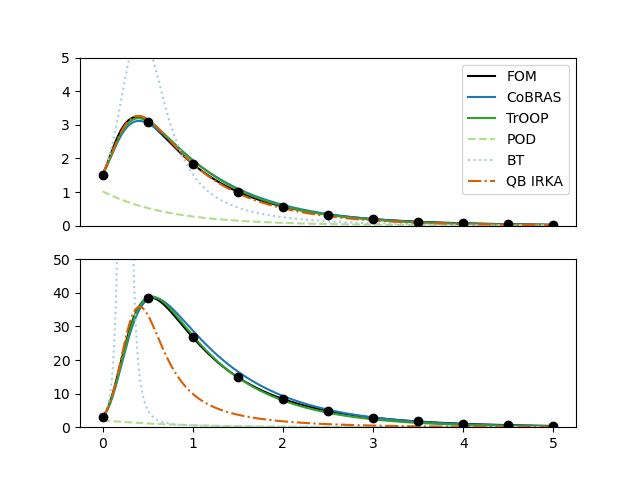

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [93]:
fig = plt.figure()

k=0
ax = fig.add_subplot(2,1,1)
ax.plot(traj_time, FOM_y_trajs[k][:,0], color='k', linestyle='-', label='FOM')
ax.plot(traj_time, cbal_y_trajs[k][:,0], color='#1f78b4', linestyle='-', label='CoBRAS')
ax.plot(traj_time, TrOOP_y_trajs[k][:,0], color='#33a02c', linestyle='-', label='TrOOP')
ax.plot(traj_time, POD_y_trajs[k][:,0], color='#b2df8a', linestyle='--', label='POD')
ax.plot(traj_time, bal_y_trajs[k][:,0], color='#a6cee3', linestyle=':', label='BT')
ax.plot(traj_time, QBIRKA_y_trajs[k][:,0], color='#d95f02', linestyle='-.', label='QB IRKA')
ax.plot(t_data, y_traj_data[k][:,0], 'ko')
ax.set_ylim([0,5])
#ax.set_ylabel('y (u={:.1f})'.format(traj_ICs[k][0]))
ax.legend()
ax.set_xticks([])

k=1
ax = fig.add_subplot(2,1,2)
ax.plot(traj_time, FOM_y_trajs[k][:,0], color='k', linestyle='-', label='FOM')
ax.plot(traj_time, cbal_y_trajs[k][:,0], color='#1f78b4', linestyle='-', label='CoBRAS')
ax.plot(traj_time, TrOOP_y_trajs[k][:,0], color='#33a02c', linestyle='-', label='TrOOP')
ax.plot(traj_time, POD_y_trajs[k][:,0], color='#b2df8a', linestyle='--', label='POD')
ax.plot(traj_time, bal_y_trajs[k][:,0], color='#a6cee3', linestyle=':', label='BT')
ax.plot(traj_time, QBIRKA_y_trajs[k][:,0], color='#d95f02', linestyle='-.', label='QB IRKA')
ax.plot(t_data, y_traj_data[k][:,0], 'ko')
ax.set_ylim([0,50])
#ax.set_ylabel('y (u={:.1f})'.format(traj_ICs[k][0]))

# ax.set_xlabel('t')

# plt.savefig('figures/toy_model/training_trajectories.png', dpi=None, facecolor='w', edgecolor='w', \
#             transparent=False, bbox_inches=None, pad_inches=0.0)
# plt.savefig('figures/toy_model/training_trajectories.eps', dpi=None, facecolor='w', edgecolor='w', \
#             transparent=False, bbox_inches=None, pad_inches=0.0)

plt.show()

# Test on random trajectories

In [94]:
n_traj_test = 100
traj_ICs_test = [np.ones(n_states)*np.random.uniform(0,1) for _ in range(n_traj_test)]
# traj_ICs_test = [np.ones(n_states)*1.0 for _ in range(n_traj_test)]

u_trajs_test = [np.reshape(0.0*traj_time, (-1,1)) for k in range(n_traj_test)]

# FOM trajectories
FOM_x_trajs_test = [_ for _ in range(n_traj_test)]
FOM_y_trajs_test = [_ for _ in range(n_traj_test)]

# Covariance Blancing ROM trajectories
cbal_x_trajs_test = [_ for _ in range(n_traj_test)]
cbal_y_trajs_test = [_ for _ in range(n_traj_test)]

# POD ROM trajectories
POD_x_trajs_test = [_ for _ in range(n_traj_test)]
POD_y_trajs_test = [_ for _ in range(n_traj_test)]

# Balanced ROM trajectories
bal_x_trajs_test = [_ for _ in range(n_traj_test)]
bal_y_trajs_test = [_ for _ in range(n_traj_test)]

# QB Balanced ROM trajectories
QBbal_x_trajs_test = [_ for _ in range(n_traj_test)]
QBbal_y_trajs_test = [_ for _ in range(n_traj_test)]

# QB IRKA ROM trajectories
QBIRKA_x_trajs_test = [_ for _ in range(n_traj_test)]
QBIRKA_y_trajs_test = [_ for _ in range(n_traj_test)]

# optimal ROM trajectories
TrOOP_x_trajs_test = [_ for _ in range(n_traj_test)]
TrOOP_y_trajs_test = [_ for _ in range(n_traj_test)]

for k in range(n_traj_test):
    # interpolate the input
    u_fun = sp.interpolate.interp1d(traj_time, u_trajs_test[k], axis=0)
    
    # simulate the FOM
    sol = sp.integrate.solve_ivp(lambda t,z: FOM(z, u_fun(t)), \
                                 t_span = [traj_time[0], traj_time[-1]], \
                                 y0 = traj_ICs_test[k], \
                                 t_eval = traj_time, \
                                 method = solver_method, \
                                 atol=atol, rtol=rtol)
    FOM_x_trajs_test[k] = sol.y.T
    FOM_y_trajs_test[k] = FOM_obs(sol.y.T)
    
    # simulate the covariance balanced ROM
    sol = sp.integrate.solve_ivp(lambda t,z: cbal_ROM(z, u_fun(t)), \
                                 t_span = [traj_time[0], traj_time[-1]], \
                                 y0 = np.dot(Psi_cbal.T, traj_ICs_test[k]), \
                                 t_eval = traj_time, \
                                 method = solver_method, \
                                 atol=atol, rtol=rtol)
    cbal_x_trajs_test[k] = np.einsum('ij,...j', Phi_cbal, sol.y.T)
    cbal_y_trajs_test[k] = cbal_ROM_obs(sol.y.T)
    
    # simulate the POD ROM
    sol = sp.integrate.solve_ivp(lambda t,z: POD_ROM(z, u_fun(t)), \
                                 t_span = [traj_time[0], traj_time[-1]], \
                                 y0 = np.dot(Psi_POD.T, traj_ICs_test[k]), \
                                 t_eval = traj_time, \
                                 method = solver_method, \
                                 atol=atol, rtol=rtol)
    POD_x_trajs_test[k] = np.einsum('ij,...j', Phi_POD, sol.y.T)
    POD_y_trajs_test[k] = POD_ROM_obs(sol.y.T)
    
    # simulate the balanced ROM
    sol = sp.integrate.solve_ivp(lambda t,z: bal_ROM(z, u_fun(t)), \
                                 t_span = [traj_time[0], traj_time[-1]], \
                                 y0 = np.dot(Psi_bal.T, traj_ICs_test[k]), \
                                 t_eval = traj_time, \
                                 method = solver_method, \
                                 atol=atol, rtol=rtol)
    bal_x_trajs_test[k] = np.einsum('ij,...j', Phi_bal, sol.y.T)
    bal_y_trajs_test[k] = bal_ROM_obs(sol.y.T)
    
    # simulate the QB balanced ROM
    sol = sp.integrate.solve_ivp(lambda t,z: QBbal_ROM(z, u_fun(t)), \
                                 t_span = [traj_time[0], traj_time[-1]], \
                                 y0 = np.dot(Psi_QBbal.T, traj_ICs_test[k]), \
                                 t_eval = traj_time, \
                                 method = solver_method, \
                                 atol=atol, rtol=rtol)
    QBbal_x_trajs_test[k] = np.einsum('ij,...j', Phi_QBbal, sol.y.T)
    QBbal_y_trajs_test[k] = QBbal_ROM_obs(sol.y.T)
    
    # simulate the QB IRKA ROM
    sol = sp.integrate.solve_ivp(lambda t,z: QBIRKA_ROM(z, u_fun(t)), \
                                 t_span = [traj_time[0], traj_time[-1]], \
                                 y0 = np.dot(Psi_QBIRKA.T, traj_ICs_test[k]), \
                                 t_eval = traj_time, \
                                 method = solver_method, \
                                 atol=atol, rtol=rtol)
    QBIRKA_x_trajs_test[k] = np.einsum('ij,...j', Phi_QBIRKA, sol.y.T)
    QBIRKA_y_trajs_test[k] = QBIRKA_ROM_obs(sol.y.T)
    
    # simulate the TrOOP ROM
    sol = sp.integrate.solve_ivp(lambda t,z: TrOOP_ROM(z, u_fun(t)), \
                                 t_span = [traj_time[0], traj_time[-1]], \
                                 y0 = np.dot(Psi_TrOOP.T, traj_ICs_test[k]), \
                                 t_eval = traj_time, \
                                 method = solver_method, \
                                 atol=atol, rtol=rtol)
    TrOOP_x_trajs_test[k] = np.einsum('ij,...j', Phi_TrOOP, sol.y.T)
    TrOOP_y_trajs_test[k] = TrOOP_ROM_obs(sol.y.T)

In [95]:
# square error normalized by average output energy along each trajectory

cbal_sq_errors = [np.square(np.linalg.norm( cbal_y_trajs_test[k] - FOM_y_trajs_test[k], axis=1 )) / \
                      np.mean(np.square(np.linalg.norm( FOM_y_trajs_test[k], axis=1 ))) for k in range(n_traj_test)]

POD_sq_errors = [np.square(np.linalg.norm( POD_y_trajs_test[k] - FOM_y_trajs_test[k], axis=1 )) / \
                      np.mean(np.square(np.linalg.norm( FOM_y_trajs_test[k], axis=1 ))) for k in range(n_traj_test)]

bal_sq_errors = [np.square(np.linalg.norm( bal_y_trajs_test[k] - FOM_y_trajs_test[k], axis=1 )) / \
                      np.mean(np.square(np.linalg.norm( FOM_y_trajs_test[k], axis=1 ))) for k in range(n_traj_test)]

QBbal_sq_errors = [np.square(np.linalg.norm( QBbal_y_trajs_test[k] - FOM_y_trajs_test[k], axis=1 )) / \
                      np.mean(np.square(np.linalg.norm( FOM_y_trajs_test[k], axis=1 ))) for k in range(n_traj_test)]

QBIRKA_sq_errors = [np.square(np.linalg.norm( QBIRKA_y_trajs_test[k] - FOM_y_trajs_test[k], axis=1 )) / \
                      np.mean(np.square(np.linalg.norm( FOM_y_trajs_test[k], axis=1 ))) for k in range(n_traj_test)]

TrOOP_sq_errors = [np.square(np.linalg.norm( TrOOP_y_trajs_test[k] - FOM_y_trajs_test[k], axis=1 )) / \
                     np.mean(np.square(np.linalg.norm( FOM_y_trajs_test[k], axis=1 ))) for k in range(n_traj_test)]

<IPython.core.display.Javascript object>


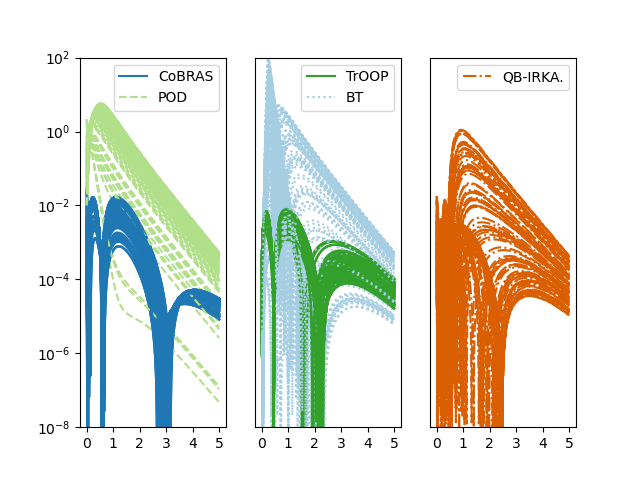

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [97]:
fig = plt.figure()

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.semilogy(traj_time, cbal_sq_errors[k], color='#1f78b4', linestyle='-', label='CoBRAS')
ax1.semilogy(traj_time, POD_sq_errors[k], color='#b2df8a', linestyle='--', label='POD')
ax2.semilogy(traj_time, TrOOP_sq_errors[k], color='#33a02c', linestyle='-', label='TrOOP')
ax2.semilogy(traj_time, bal_sq_errors[k], color='#a6cee3', linestyle=':', label='BT')
ax3.semilogy(traj_time, QBIRKA_sq_errors[k], color='#d95f02', linestyle='-.', label='QB-IRKA.')
for k in range(1, n_traj_test):
    ax1.semilogy(traj_time, cbal_sq_errors[k], color='#1f78b4', linestyle='-')
    ax1.semilogy(traj_time, POD_sq_errors[k], color='#b2df8a', linestyle='--')
    ax2.semilogy(traj_time, TrOOP_sq_errors[k], color='#33a02c', linestyle='-')
    ax2.semilogy(traj_time, bal_sq_errors[k], color='#a6cee3', linestyle=':')
    ax3.semilogy(traj_time, QBIRKA_sq_errors[k], color='#d95f02', linestyle='-.')

# ax1.set_ylabel('normalized square error')

# ax1.set_xlabel('t')
# ax2.set_xlabel('t')
# ax3.set_xlabel('t')

#axs[1].set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])

ax1.set_xticks(np.arange(6))
ax2.set_xticks(np.arange(6))
ax3.set_xticks(np.arange(6))

ax1.set_ylim([1.0e-8, 1.0e2])
ax2.set_ylim([1.0e-8, 1.0e2])
ax3.set_ylim([1.0e-8, 1.0e2])

ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')

# plt.savefig('figures/toy_model/test_data_normalized_square_error.png', dpi=None, facecolor='w', edgecolor='w', \
#             transparent=False, bbox_inches=None, pad_inches=0.0)
# plt.savefig('figures/toy_model/test_data_normalized_square_error.eps', dpi=None, facecolor='w', edgecolor='w', \
#             transparent=False, bbox_inches=None, pad_inches=0.0)

plt.show()

## Sinusoidal input

In [98]:
traj_time_sin = np.linspace(0,10*np.pi, 1001)

# initial condition
x_0 = np.zeros(n_states)

# input signal
u_fun = lambda t: np.sin(t)*np.ones(n_inputs)

# simulate the FOM
sol = sp.integrate.solve_ivp(lambda t,z: FOM(z, u_fun(t)), \
                             t_span = [traj_time_sin[0], traj_time_sin[-1]], \
                             y0 = x_0, \
                             t_eval = traj_time_sin, \
                             method = solver_method, \
                             atol=atol, rtol=rtol)
FOM_x_traj_sin = sol.y.T
FOM_y_traj_sin = FOM_obs(sol.y.T)

# simulate the covariance balancing ROM
sol = sp.integrate.solve_ivp(lambda t,z: cbal_ROM(z, u_fun(t)), \
                             t_span = [traj_time_sin[0], traj_time_sin[-1]], \
                             y0 = np.dot(Psi_cbal.T, x_0), \
                             t_eval = traj_time_sin, \
                             method = solver_method, \
                             atol=atol, rtol=rtol)
cbal_x_traj_sin = np.einsum('ij,...j', Phi_cbal, sol.y.T)
cbal_y_traj_sin = cbal_ROM_obs(sol.y.T)

# simulate the POD ROM
sol = sp.integrate.solve_ivp(lambda t,z: POD_ROM(z, u_fun(t)), \
                             t_span = [traj_time_sin[0], traj_time_sin[-1]], \
                             y0 = np.dot(Psi_POD.T, x_0), \
                             t_eval = traj_time_sin, \
                             method = solver_method, \
                             atol=atol, rtol=rtol)
POD_x_traj_sin = np.einsum('ij,...j', Phi_POD, sol.y.T)
POD_y_traj_sin = POD_ROM_obs(sol.y.T)
    
# simulate the balanced ROM
sol = sp.integrate.solve_ivp(lambda t,z: bal_ROM(z, u_fun(t)), \
                             t_span = [traj_time_sin[0], traj_time_sin[-1]], \
                             y0 = np.dot(Psi_bal.T, x_0), \
                             t_eval = traj_time_sin, \
                             method = solver_method, \
                             atol=atol, rtol=rtol)
bal_x_traj_sin = np.einsum('ij,...j', Phi_bal, sol.y.T)
bal_y_traj_sin = bal_ROM_obs(sol.y.T)

# simulate the QB balanced ROM
sol = sp.integrate.solve_ivp(lambda t,z: QBbal_ROM(z, u_fun(t)), \
                             t_span = [traj_time_sin[0], traj_time_sin[-1]], \
                             y0 = np.dot(Psi_QBbal.T, x_0), \
                             t_eval = traj_time_sin, \
                             method = solver_method, \
                             atol=atol, rtol=rtol)
QBbal_x_traj_sin = np.einsum('ij,...j', Phi_QBbal, sol.y.T)
QBbal_y_traj_sin = QBbal_ROM_obs(sol.y.T)

# simulate the QB IRKA ROM
sol = sp.integrate.solve_ivp(lambda t,z: QBIRKA_ROM(z, u_fun(t)), \
                             t_span = [traj_time_sin[0], traj_time_sin[-1]], \
                             y0 = np.dot(Psi_QBIRKA.T, x_0), \
                             t_eval = traj_time_sin, \
                             method = solver_method, \
                             atol=atol, rtol=rtol)
QBIRKA_x_traj_sin = np.einsum('ij,...j', Phi_QBIRKA, sol.y.T)
QBIRKA_y_traj_sin = QBIRKA_ROM_obs(sol.y.T)

# simulate the TrOOP ROM
sol = sp.integrate.solve_ivp(lambda t,z: TrOOP_ROM(z, u_fun(t)), \
                             t_span = [traj_time_sin[0], traj_time_sin[-1]], \
                             y0 = np.dot(Psi_TrOOP.T, x_0), \
                             t_eval = traj_time_sin, \
                             method = solver_method, \
                             atol=atol, rtol=rtol)
TrOOP_x_traj_sin = np.einsum('ij,...j', Phi_TrOOP, sol.y.T)
TrOOP_y_traj_sin = TrOOP_ROM_obs(sol.y.T)

<IPython.core.display.Javascript object>


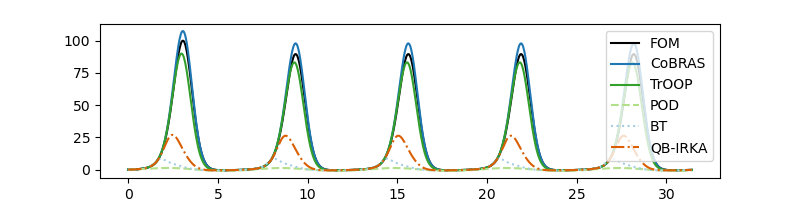

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [99]:
plt.figure(figsize=(8, 2))

plt.plot(traj_time_sin, FOM_y_traj_sin[:,0], color='k', linestyle='-', label='FOM')
plt.plot(traj_time_sin, cbal_y_traj_sin[:,0], color='#1f78b4', linestyle='-', label='CoBRAS')
plt.plot(traj_time_sin, TrOOP_y_traj_sin[:,0], color='#33a02c', linestyle='-', label='TrOOP')
plt.plot(traj_time_sin, POD_y_traj_sin[:,0], color='#b2df8a', linestyle='--', label='POD')
plt.plot(traj_time_sin, bal_y_traj_sin[:,0], color='#a6cee3', linestyle=':', label='BT')
plt.plot(traj_time_sin, QBIRKA_y_traj_sin[:,0], color='#d95f02', linestyle='-.', label='QB-IRKA')

# plt.xlabel('t')
# plt.ylabel('y')

plt.legend()

# plt.savefig('figures/toy_model/sinusoidal_response.png', dpi=None, facecolor='w', edgecolor='w', \
#             transparent=False, bbox_inches=None, pad_inches=0.0)
# plt.savefig('figures/toy_model/sinusoidal_response.eps', dpi=None, facecolor='w', edgecolor='w', \
#             transparent=False, bbox_inches=None, pad_inches=0.0)

plt.show()